In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('../DSI-CHI-1/lessons/week-08/3.1-bayes-case-study-2/assets/datasets/defaultcc.csv', header=1)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
df.columns

Index([u'ID', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE',
       u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6',
       u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6', u'default payment next month'],
      dtype='object')

In [8]:
df['default'] = df['default payment next month']

In [9]:
data = df[['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
data.head()

,default,SEX,EDUCATION,MARRIAGE,AGE
0,1,2,2,1,24
1,1,2,2,2,26
2,0,2,2,2,34
3,0,2,2,1,37
4,0,1,2,1,57


In [10]:
with pm.Model() as model:
    pm.glm.glm('default ~ SEX + EDUCATION + MARRIAGE + AGE', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)

100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s]


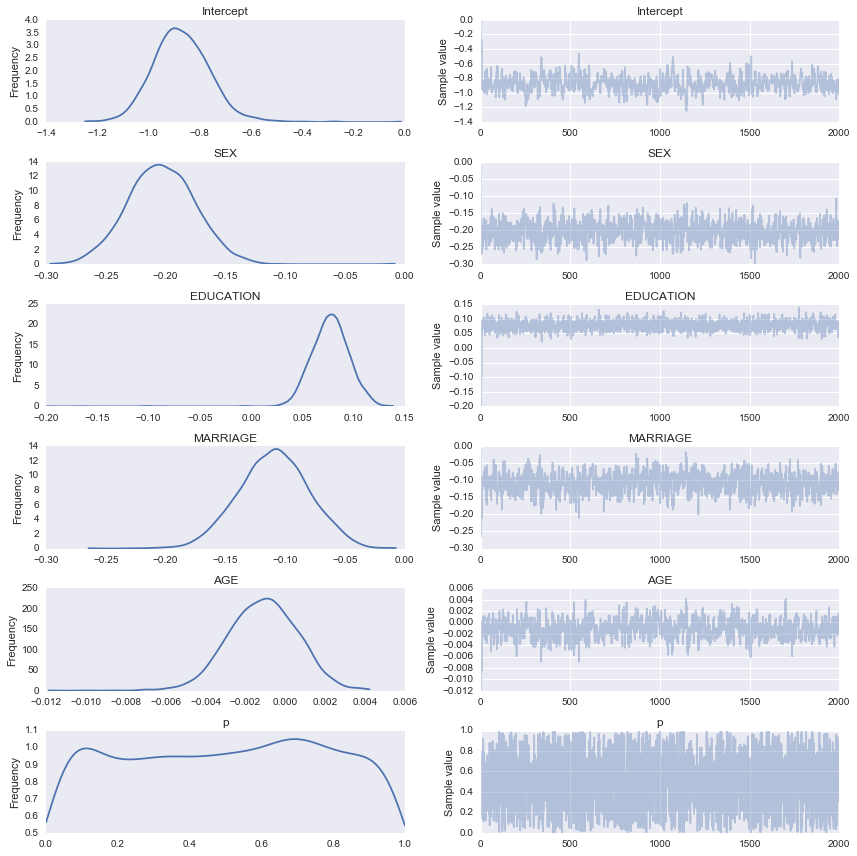

In [11]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace_logistic_model)
plt.tight_layout()


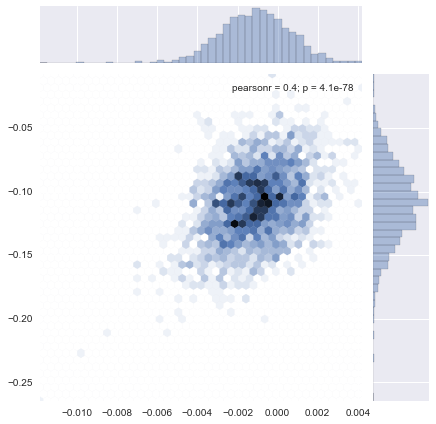

In [12]:
sns.jointplot(trace_logistic_model['AGE'], trace_logistic_model['MARRIAGE'], kind='hex')

In [13]:
# wide intervals, not super useful

pm.summary(trace_logistic_model)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.870           0.115            0.006            [-1.092, -0.664]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.074         -0.946         -0.878         -0.801         -0.630


SEX:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.203           0.029            0.001            [-0.258, -0.150]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.258         -0.223         -0.203         -0.184         -0.149


EDUCATION:

  Mean             SD               MC Error         95% HPD interval
  -------------

In [14]:
for coef in ['Intercept', 'SEX', 'AGE', 'MARRIAGE', 'EDUCATION']:
    print coef, ': ', np.mean(trace_logistic_model[coef])

Intercept :  -0.87038065234
SEX :  -0.203284396225
AGE :  -0.00111408095073
MARRIAGE :  -0.109509267236
EDUCATION :  0.0769195324263


In [15]:
import theano.tensor as T

def logistic(l):
    return 1 / (1 + T.exp(-l))

with pm.Model() as test_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sex_coef = pm.Normal('sex', mu=0, sd=100)
    marriage_coef = pm.Normal('marriage', mu=0, sd=100)
    
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)

100%|██████████| 2000/2000 [03:23<00:00, 10.68it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138215210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x134585d10>]], dtype=object)

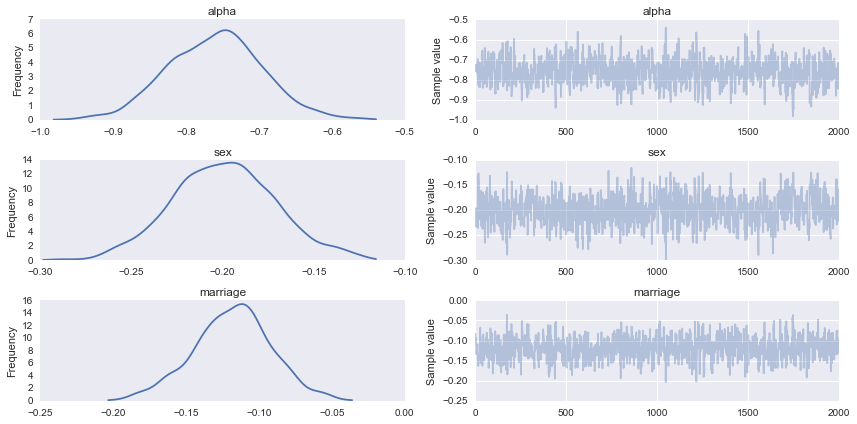

In [16]:
pm.traceplot(traces_new_logistic)

In [17]:
traces_new_logistic['sex'].mean()

-0.19916996239203666

In [18]:
traces_new_logistic['marriage'].mean()

-0.11833216319416952

In [19]:
with pm.Model() as test_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sex_coef = pm.Normal('sex', mu=0, sd=1000)
    marriage_coef = pm.Normal('marriage', mu=0.5, sd=2)
    
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)

100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s]


In [20]:
import theano.tensor as T

def logistic(l):
    return 1 / (1 + T.exp(-l))

with pm.Model() as test_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sex_coef = pm.Bernoulli('sex', p=0.5)
#     sex_coef = pm.Normal('sex', mu=0, sd=100)
#     marriage_coef = pm.Normal('marriage', mu=0, sd=100)
    marriage_coef = pm.Categorical('marriage', p=np.array([0.53, 0.45, 0.01, 0.01]))
    
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)

100%|██████████| 2000/2000 [00:55<00:00, 36.01it/s]
